# Wine Quality - Multiclass Classification Problem

The goal of this project is to predict wine quality based on physicochemical tests. The quality scala features descrete values from 3 to 9, with 3 refering to the lowest quality and 9 being a top grade. 

We will approach the problem as a **multiclass classification** task, although it can also be solved by means of regression algorithms.

As models' performance metrics, we will use *accuracy*, *f1-measure*, *recall* and *precision*.

We are dealing here with [rather clean, structured data](https://query.data.world/s/i7ryk6swyw4zylwytuw66dciymeps4). Some new techniques I implemented in the course of the project are:

* Calculating feature importance using *Mutual Information Statistics* & *ANOVA F-test*
* Oversampling to solve imbalance classes issue
* Feature engineering using `PolynomialFeatures` from sklearn
* Feature selection with *Recursive Feature Elimination*
* Fine tuning of hyperparameters with `RandomizedSearchCV` from sklearn.

## PREPARE PROBLEM

### 1) Load libraries

In [114]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings('ignore')

# Matplotlib forms basis for visualization in Python
import matplotlib.pyplot as plt

# We will use the Seaborn library
import seaborn as sns
sns.set()

# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'

In [115]:
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest, RFE
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier

### 2) Load dataset

In [116]:
# loading our data
df = pd.read_csv('https://query.data.world/s/i7ryk6swyw4zylwytuw66dciymeps4', delimiter=';')
# set up random state number
seed = 29

## ANALIZE DATA

### 1) Descriptive statistics

Let's first take a quick look at our data:

In [117]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [118]:
df.shape

(4898, 12)

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


There are 4898 observations and 11 independent variables in our dataset. All variables are numeric, and it seems like there are no missing values. `quality` is our dependent variable or target, which we will try to predict.

I will approach the problem as a **multiclass classification** task, although it can also be solved by means of regression algorithms. 

Our target variable 'quality' takes discrete numerical values from 3 (lowest wine quality) to 9 (highest wine quality).

Let's take a quick look at the breakdown of class values.

In [120]:
# class distribution
print(df.groupby('quality').size())
print('='*40)
print(df['quality'].value_counts(normalize=True).sort_index())

quality
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
dtype: int64
3    0.004083
4    0.033279
5    0.297468
6    0.448755
7    0.179665
8    0.035729
9    0.001021
Name: quality, dtype: float64


As we can see, we are dealing with severe class imbalance, with the majority of observations (~93%) corresponding to the classes 5, 6 and 7. 

The challenge of working with imbalanced datasets is that most machine learning techniques will ignore, and in turn have poor performance on, the minority class, although typically it is performance on the minority class that is most important.

We may consider implementing some **oversampling** technique to deal with class imbalance. 

Let's take a closer look at descriptive statistics of our data:

In [121]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


Some observations:

* feature values are of different scales, i.e. normalization/scaling is needed
* some features have max values that are much higher than the 75th percentile, which indicates outliers
* our target variable is most likely normally distributed as its mean & median have (almost) the same value of 6

### 2) Univariate data visualization

We now take a look a closer look at our features by visualizing them.

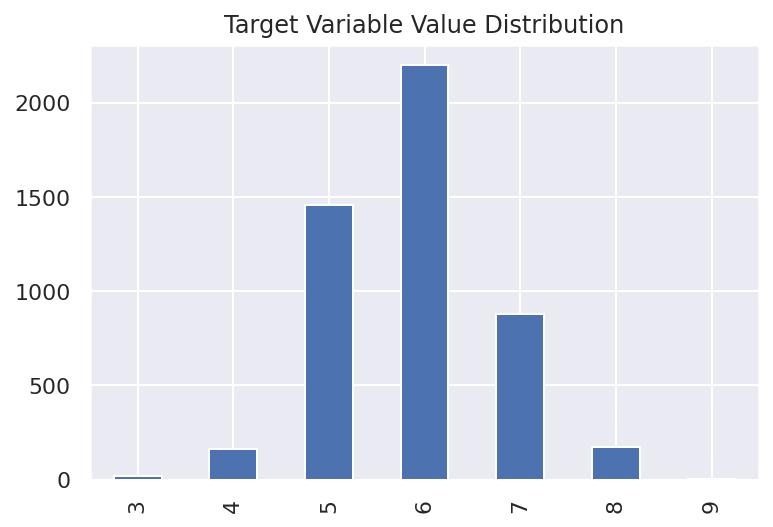

In [122]:
df.quality.value_counts().sort_index().plot(kind='bar', title='Target Variable Value Distribution');

As expected, our target variable is normaly distributed, with the majority of observations taking values 5, 6 and 7.

Let's take a look at distributions of our predictors:

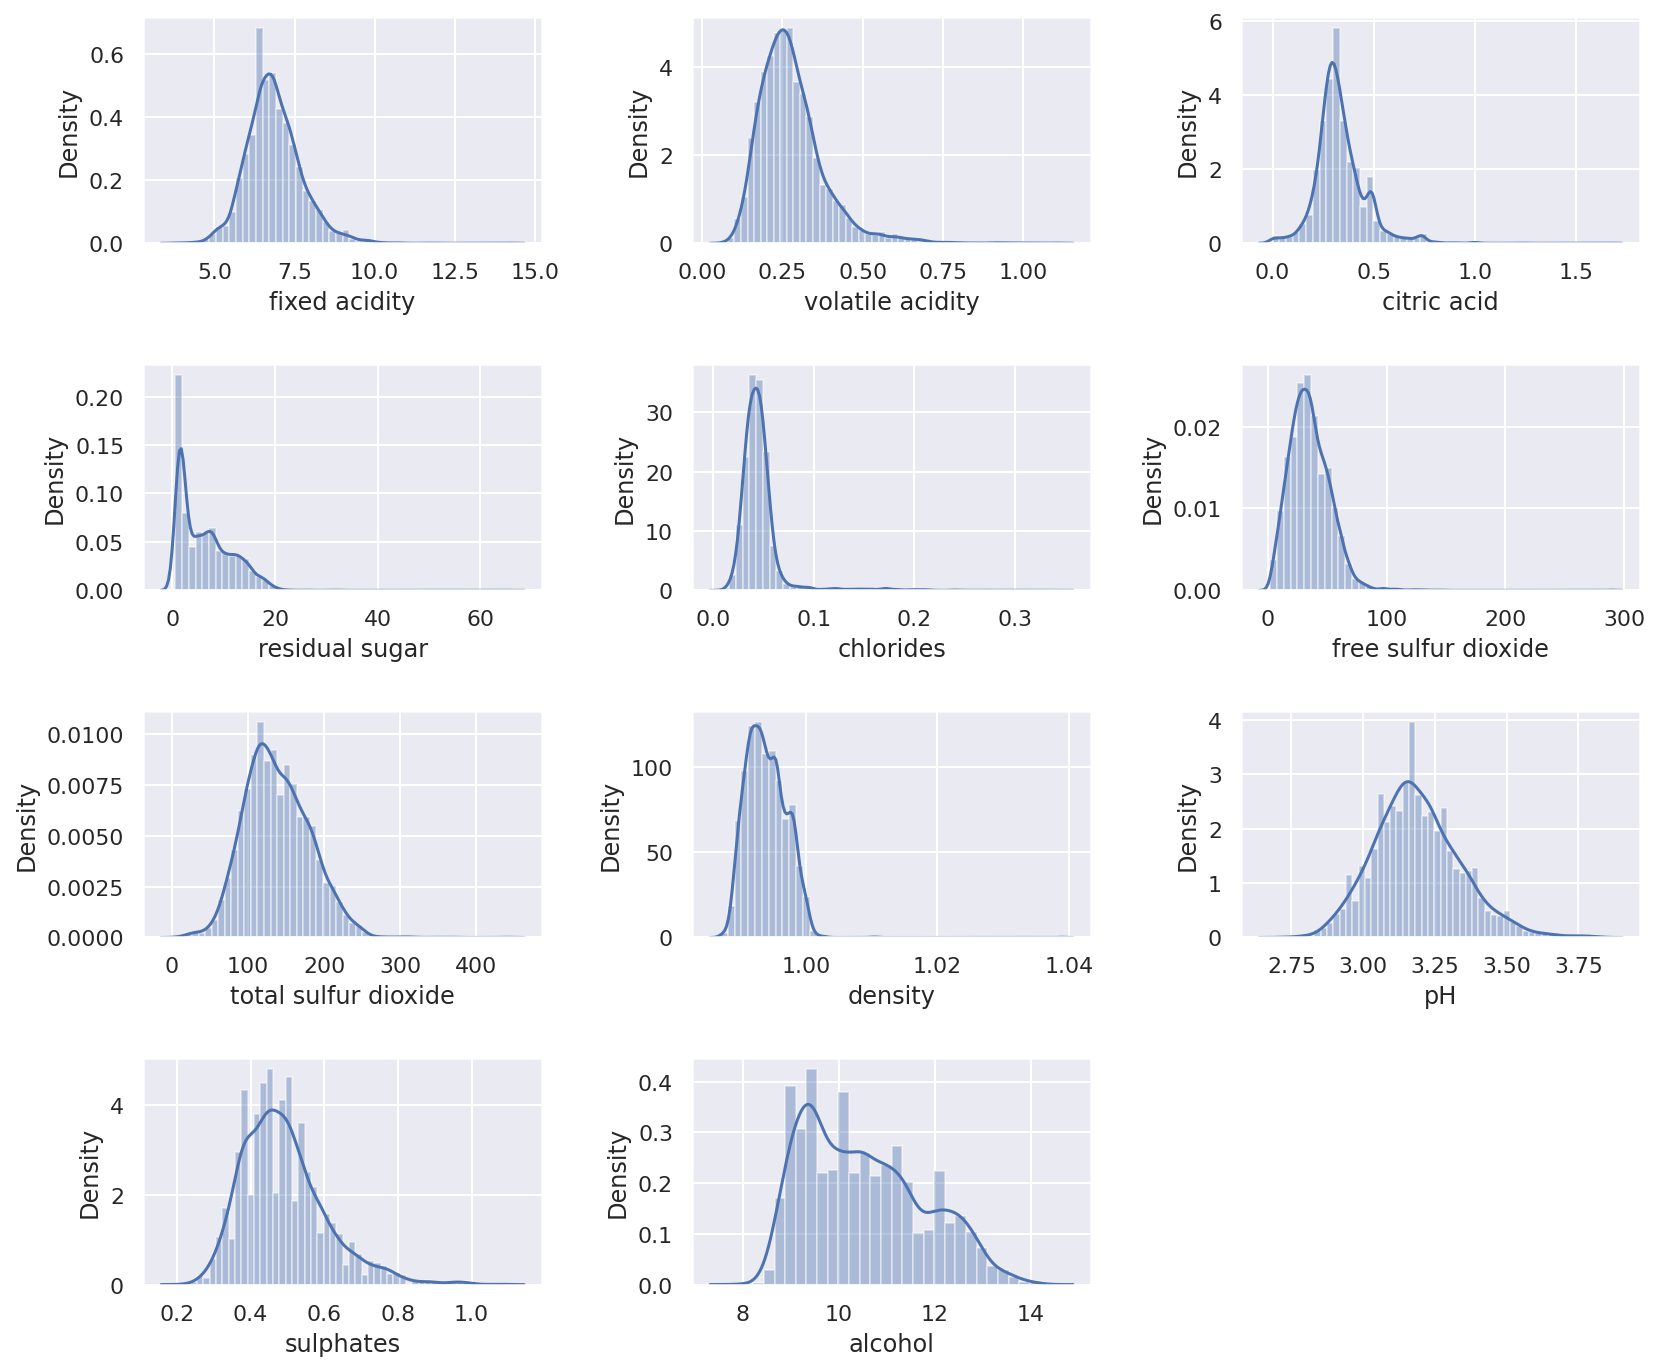

In [123]:
fig = plt.figure(figsize=(12, 10))

for index, col in enumerate(df.columns[:-1]):
    plt.subplot(4, 3, index+1)
    f = sns.distplot(df[col])
fig.tight_layout(pad=2.0)

Almost all of our independant variables have bell-shaped distribution with right skewness, which indicates outliers. Values of the variable `alcohol` are more or less evenly distributed on the range between 8.5 and 13. Distribution of `residual sugar` values resembles exponential distribution with the majority of values converging to zero.

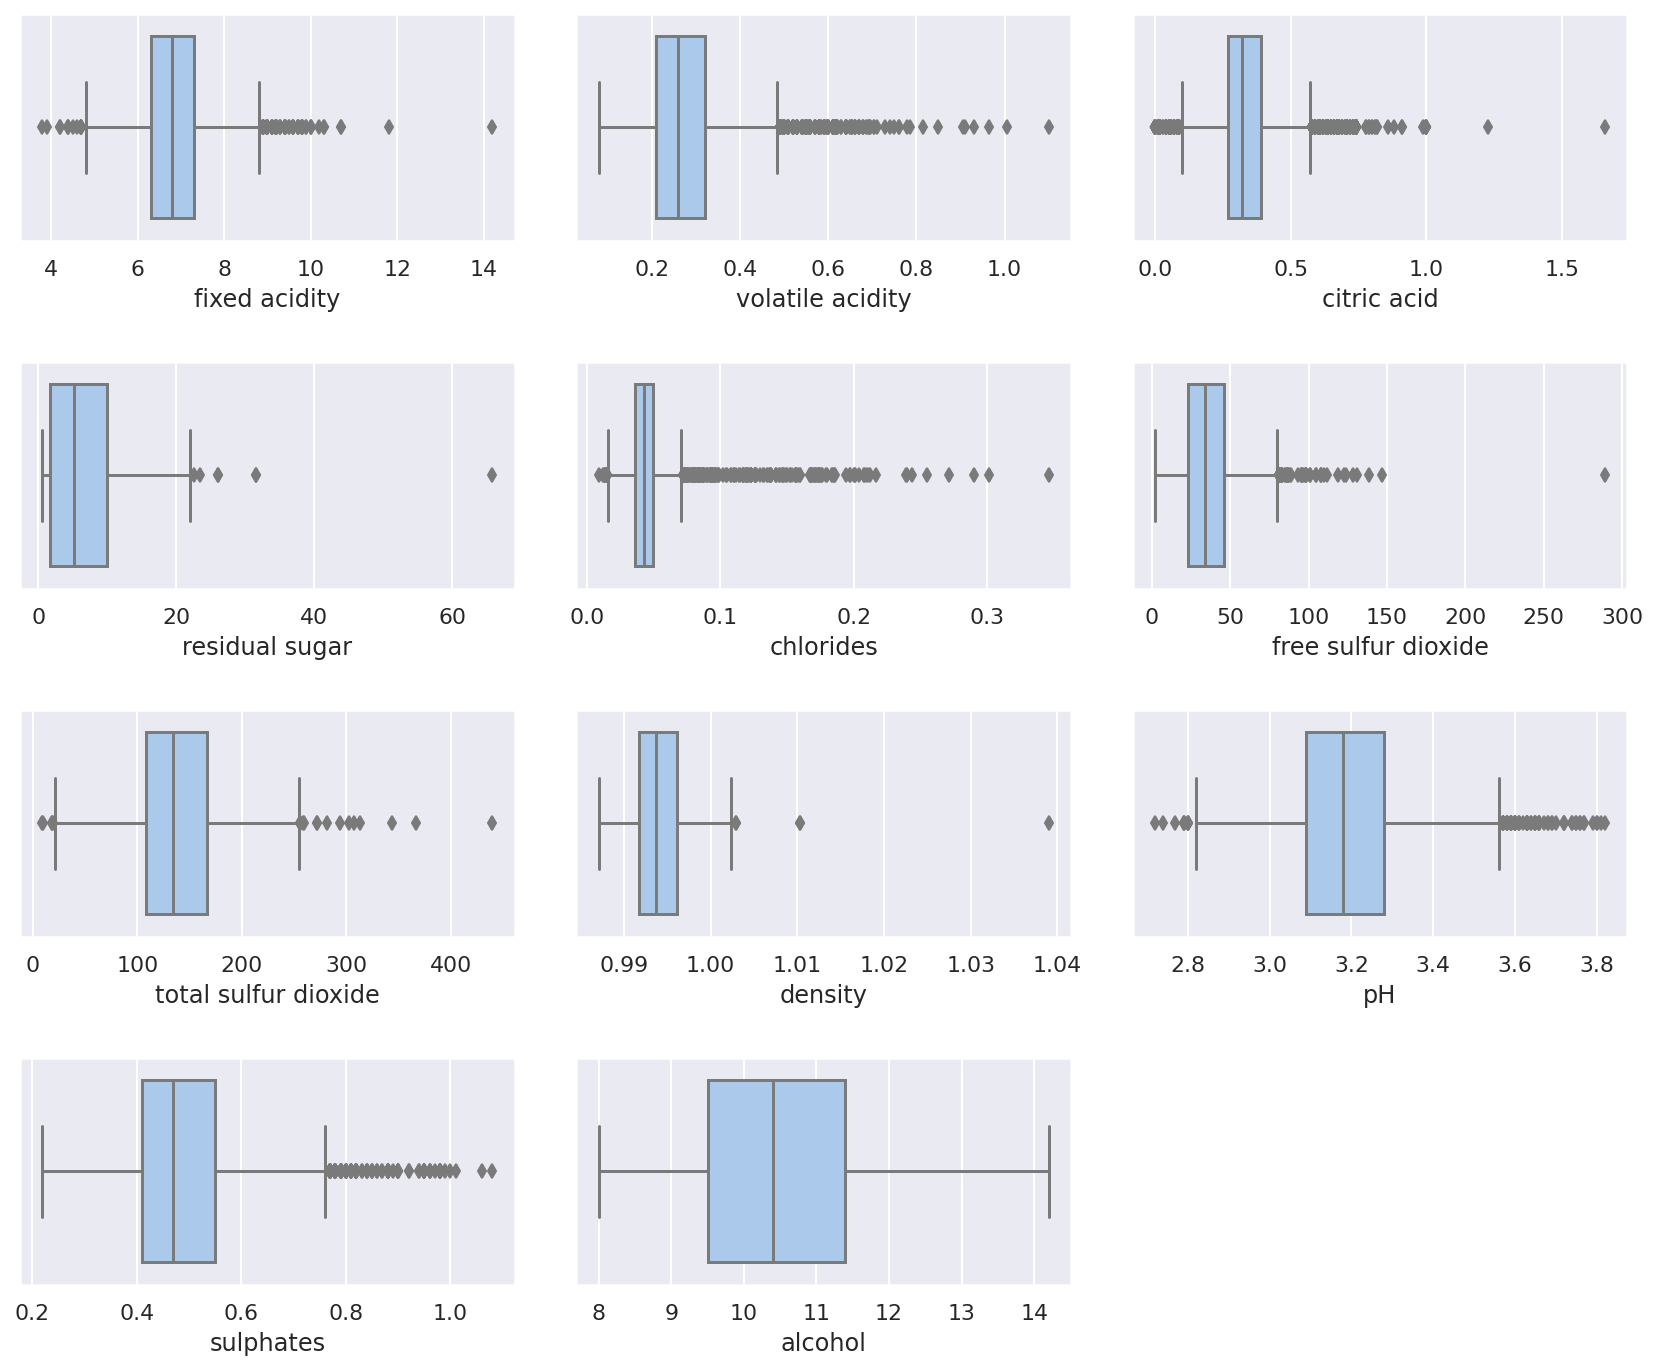

In [124]:
fig = plt.figure(figsize=(12, 10))

for index, col in enumerate(df.columns[:-1]):
    plt.subplot(4, 3, index+1)
    f = sns.boxplot(x=col, data=df, palette = "pastel")
fig.tight_layout(pad=2.0)

On the boxplots above we can clearly see that the majority of independatnt variables (`fixed acidity, volatile acidity, critic acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density`) have outliers. 

We will remove the outliers before we proceed to multimodal data visualization.

### 3) Data Cleaning

First off, let's check if there are duplicates in our dataset:

In [125]:
df.duplicated().sum()

937

Wow... One fifth of the observations are duplicates! Although it is always painful to lose data, the duplicate won't provide any useful insights for the model; we have to remove them.

In [126]:
df.drop_duplicates(inplace=True)
print(df.shape)
num_rows_before_cleaning = df.shape[0]

(3961, 12)


We can now deal with outliers.

We will remove values that lie outside 3 times the Interquartile Range (IQR). The IQR can be calculated as the difference between the 75th and 25th percentiles.

Upper Thresholds: [10.3, 0.69, 0.75, 30.8, 0.1, 111.0, 346.0, 1.01, 3.89, 0.97, 17.1]
Lower Thresholds: [3.3, -0.15, -0.09, -20.3, -0.01, -43.0, -74.0, 0.98, 2.49, -0.01, 3.8]



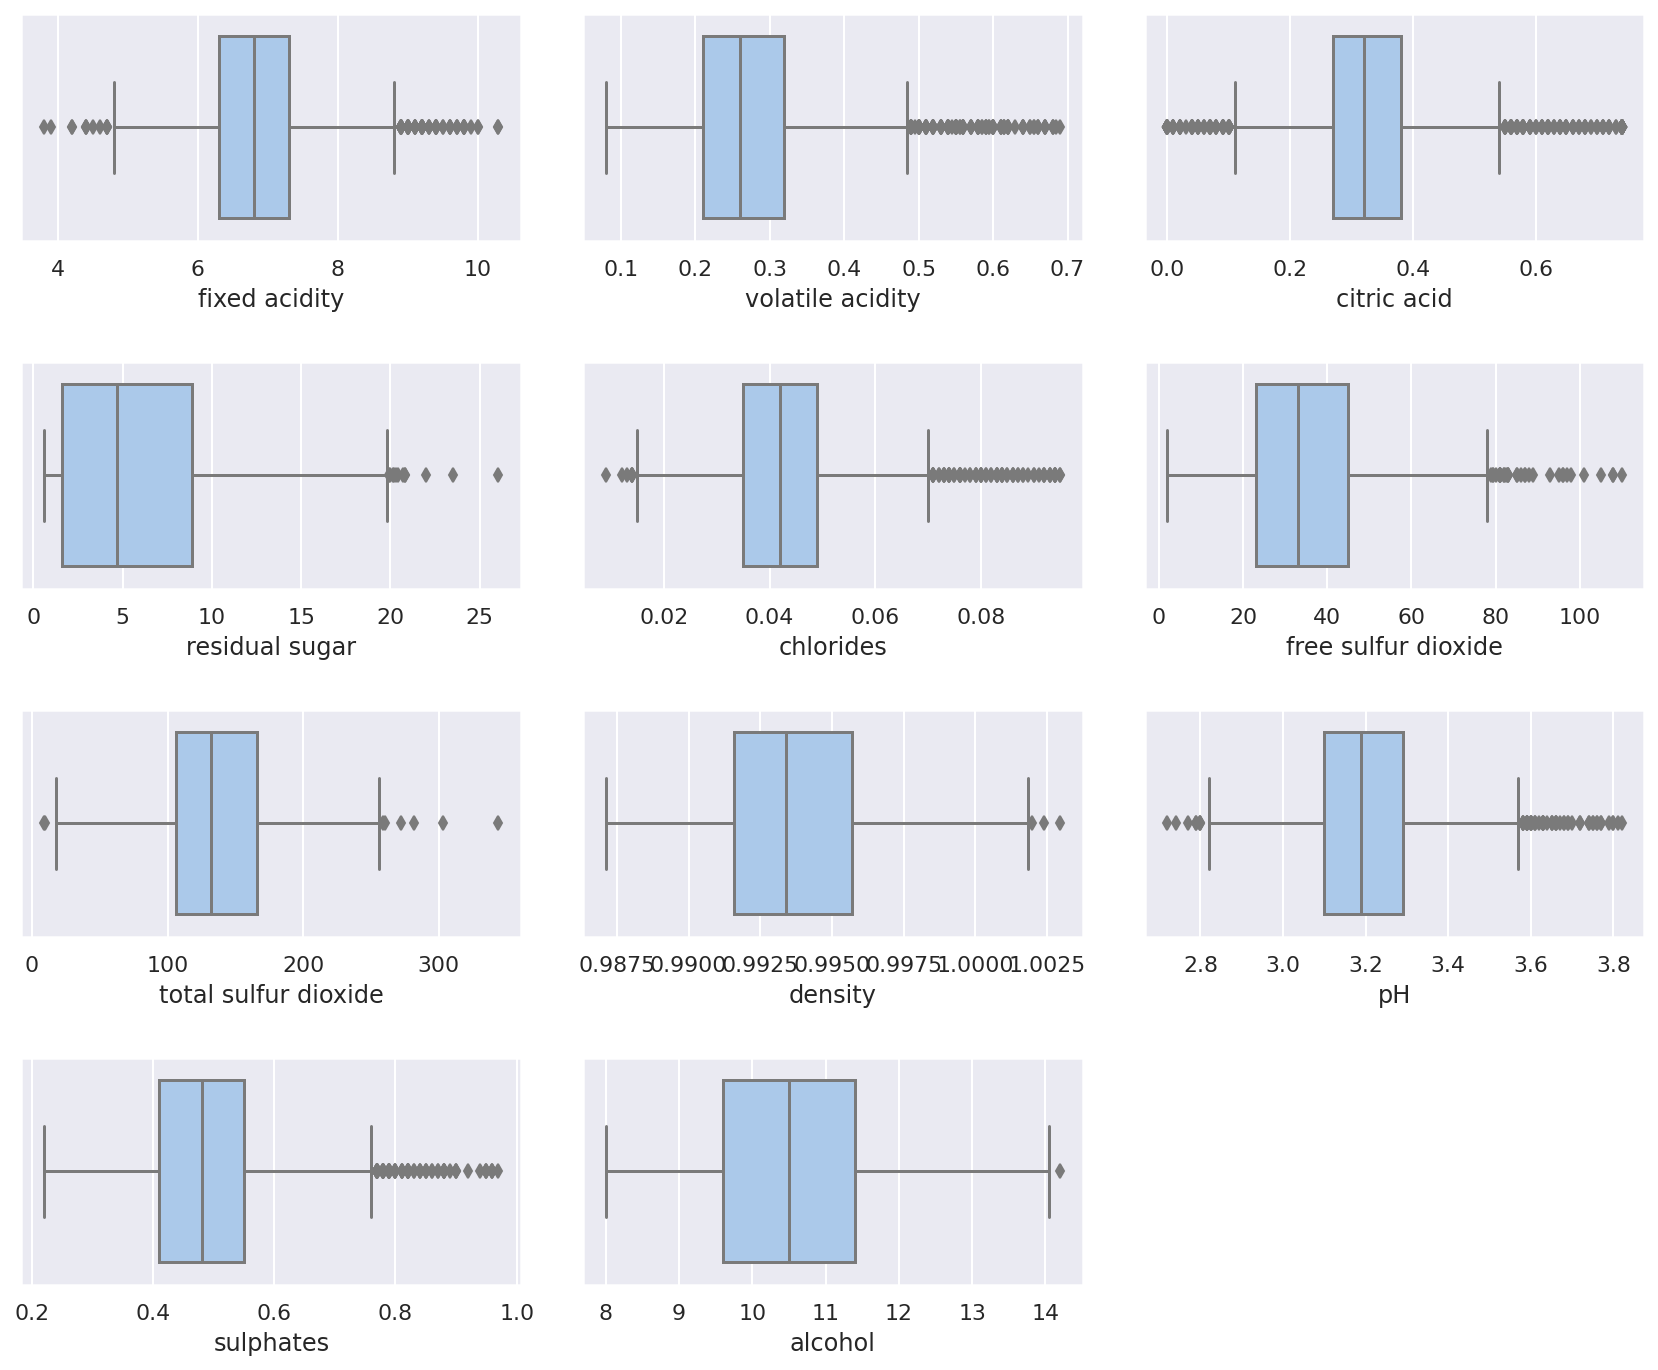

In [127]:
# set empty lists for the upper & lower threshold
upper_threshold = []
lower_threshold = []

# collecting datapotins lying outside thresholds 
for item in df.columns[:-1]:
    q25, q75 = np.percentile(df[item], 25), np.percentile(df[item], 75)
    iqr = q75 - q25
    cut_off = iqr * 3
    upper = q75 + cut_off
    lower = q25 - cut_off
    upper_threshold.append(upper)
    lower_threshold.append(lower)
    
print(f'Upper Thresholds: {[round(x, 2) for x in upper_threshold]}')
print('='*85)
print(f'Lower Thresholds: {[round(x, 2) for x in lower_threshold]}')
print()

# removing outliers in our independable variables
for idx, item in enumerate(df.columns[:-1]):
    df.drop(df[(df[item]<lower_threshold[idx])].index, inplace=True)
    df.drop(df[(df[item]>upper_threshold[idx])].index, inplace=True)
    
fig = plt.figure(figsize=(12, 10))
for index, col in enumerate(df.columns[:-1]):
    plt.subplot(4, 3, index+1)
    f = sns.boxplot(x=col, data=df, palette = "pastel")
    # f.set(ylim=(0, 2))
fig.tight_layout(pad=2.0)

In [128]:
num_rows_after_cleaning = df.shape[0]
num_lost_rows = num_rows_before_cleaning - num_rows_after_cleaning
print(f'We lost {num_lost_rows} rows due to outliers romoval')

We lost 163 rows due to outliers romoval


### 4) Multivariate data visualization

As a next step, we conduct a miltivariate data analysis to discovere relationships between variables.

Since all of our independant variables are numeric, we can get a lot of useful insights from a good old **correlation matrix**. We will use Spearman correlation for there are still outliers and our target variable `quality` is ordinal.

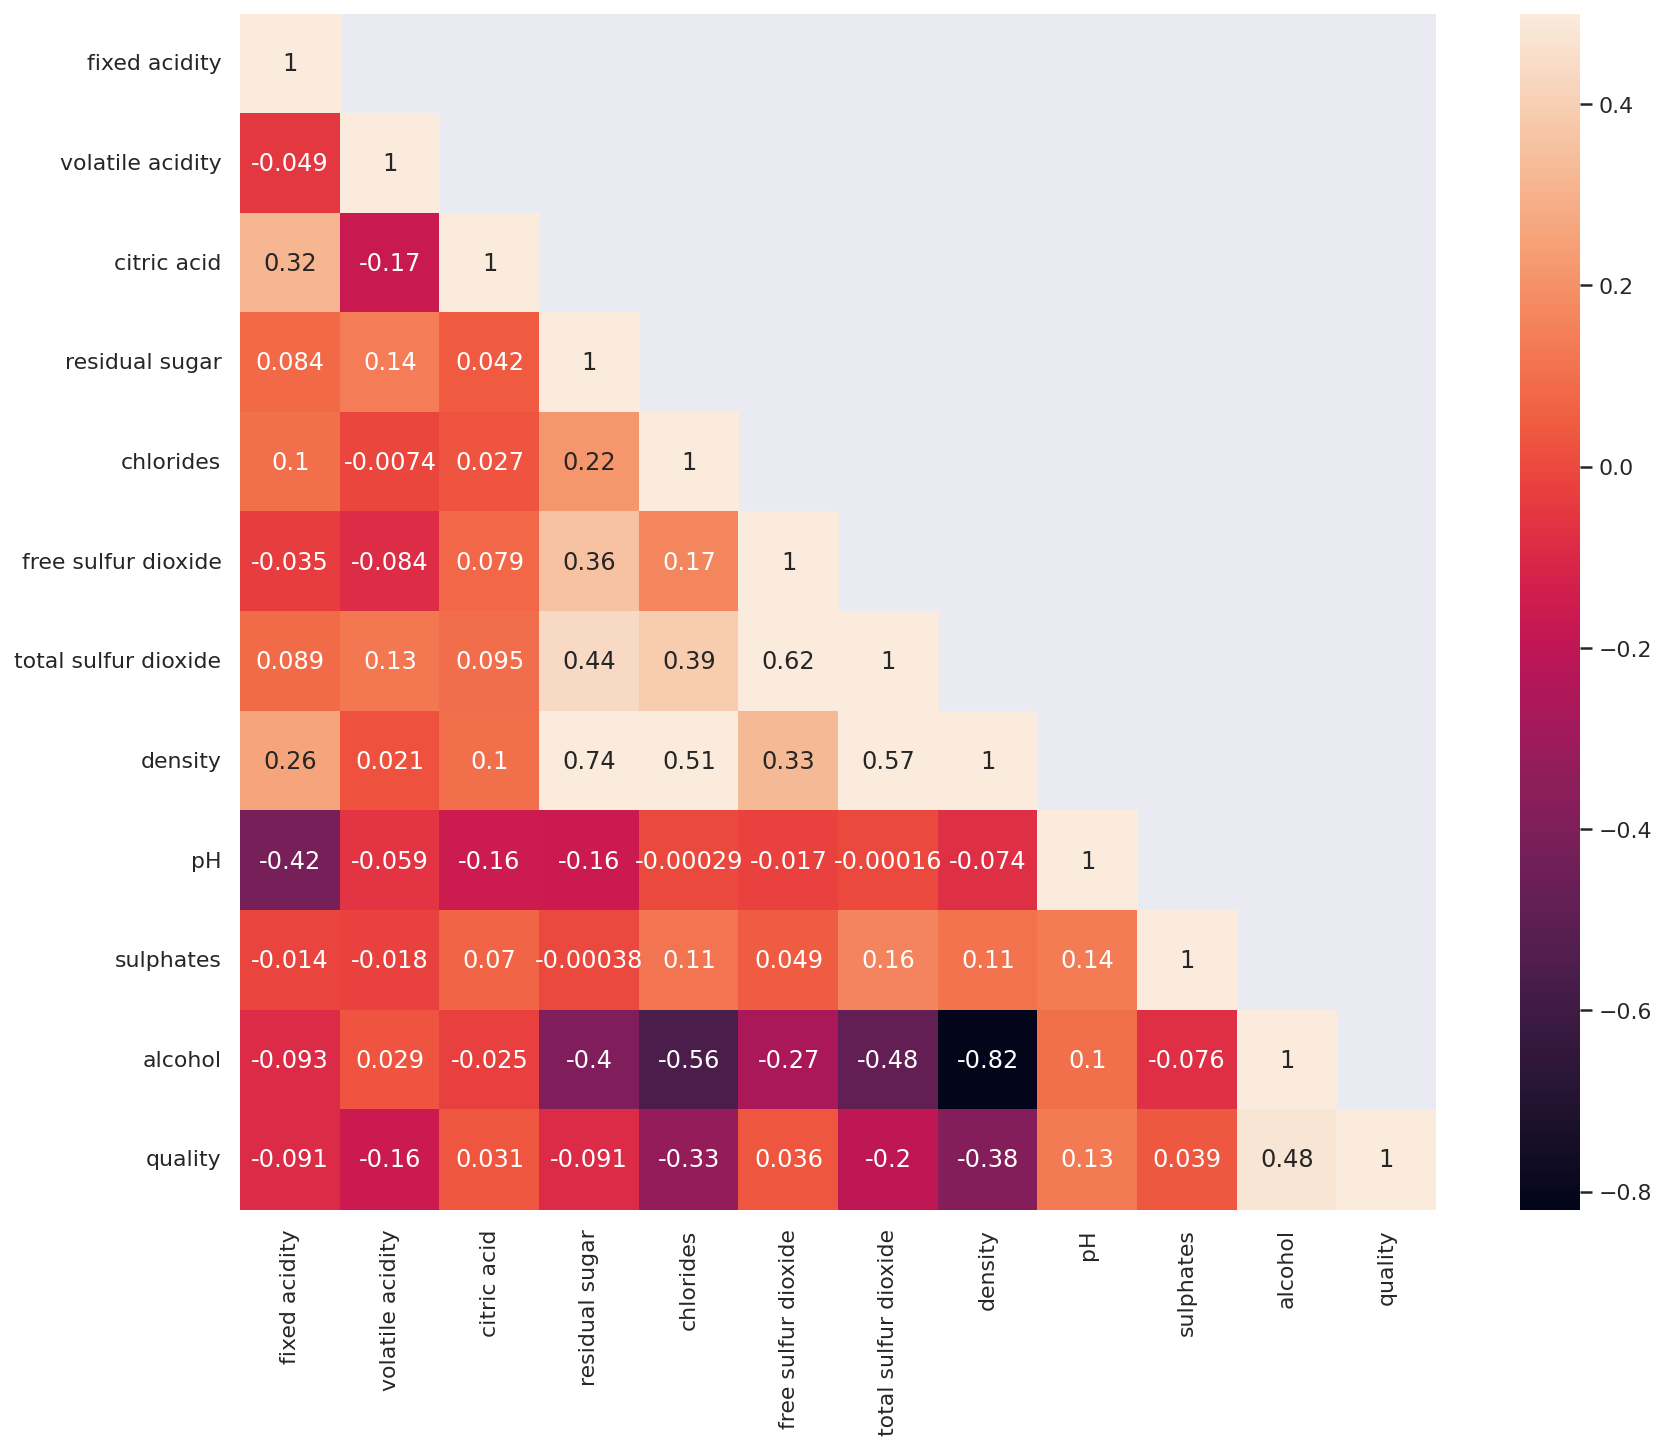

In [129]:
corr_matrix = df.corr(method='spearman')
mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False
fig, ax= plt.subplots()
fig.set_size_inches(15,11)
sns.heatmap(corr_matrix, mask=mask, vmax=.5, square=True, annot=True);

* Strong negative correlation between `alcohol` and `density`
* Strong positive correlation between `density` and `residual sugar`
* Negative correlation between `chloride` and `alcoho`
* `free supfur dioxide` and `density` are both positivly correlated with `total supfur dioxide`
* `alcohol` and `density` are variables with the strongest influence on the target variable `quality`

Let's investigate the relationship of the highly correlated variables by means of joinplots.

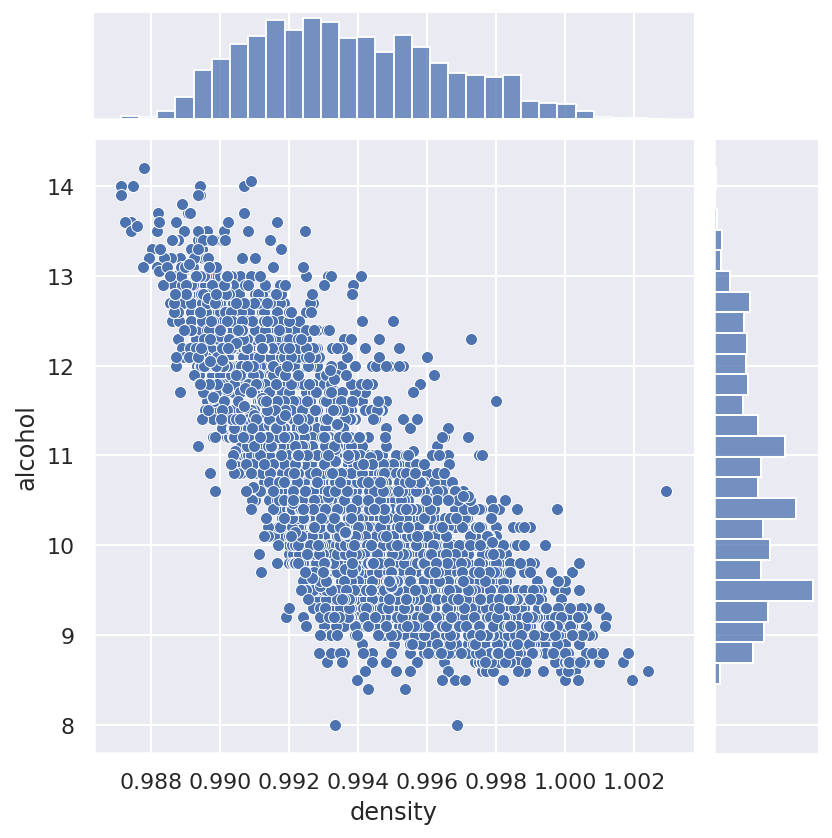

In [130]:
sns.jointplot(x='density', y='alcohol', 
              data=df, kind='scatter');

Indeed, we observe a strong negative correlation pattern. Althogh the condition of normal distribution for `alcohol` seems to be violated. We can also observe [*heteroscedasticity*](https://en.wikipedia.org/wiki/Heteroscedasticity), i.e. variability of the random disturbance is different across elements of the vector.

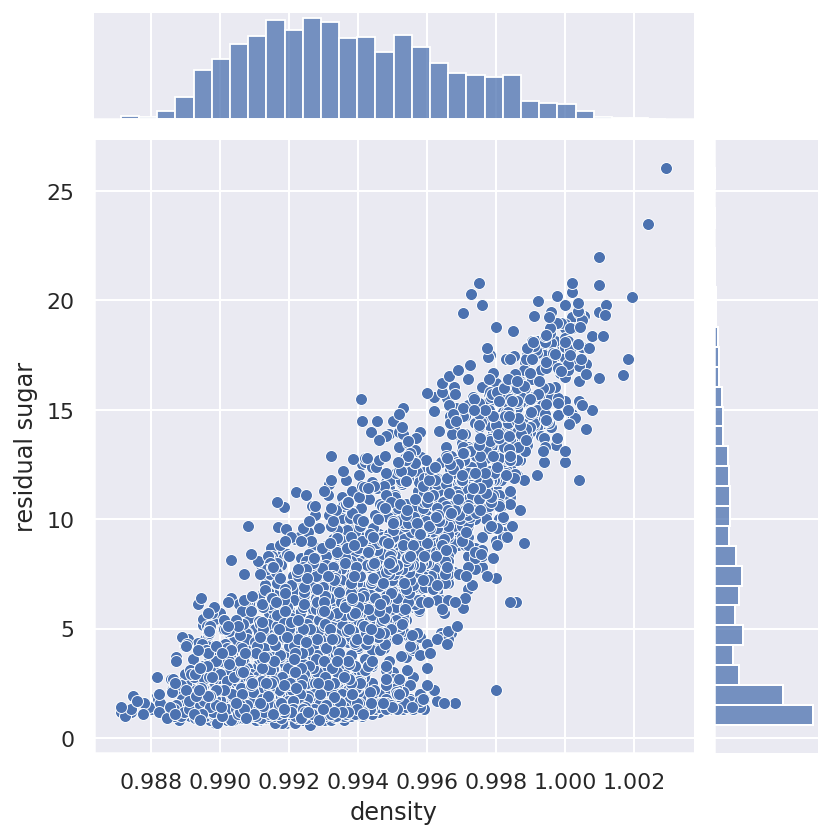

In [131]:
sns.jointplot(x='density', y='residual sugar', 
              data=df, kind='scatter');

We can make same conclusions here as for the `alcohol`-`density` pair, except that correlation between `residual sugar` and `density` is positive.

We will drop `density` and `residual sugar` to avoid multicollinearity: 

In [132]:
df.drop(['residual sugar', 'density'], 1, inplace=True)

In [133]:
# `pairplot()` may become very slow with the SVG or retina format
%config InlineBackend.figure_format = 'png'
sns.pairplot(df);

Output hidden; open in https://colab.research.google.com to view.

The pairplot does not provide us with any new information. As expected, we see a quite strong correlation pattern between `free sulfur dioxide` and `total sulfur dioxide`. I would also mention a negative correlation between `alcohol` and `chlorides`.

In [134]:
%config InlineBackend.figure_format = 'retina'

Now let's compare the feature distributions for each target variable value.

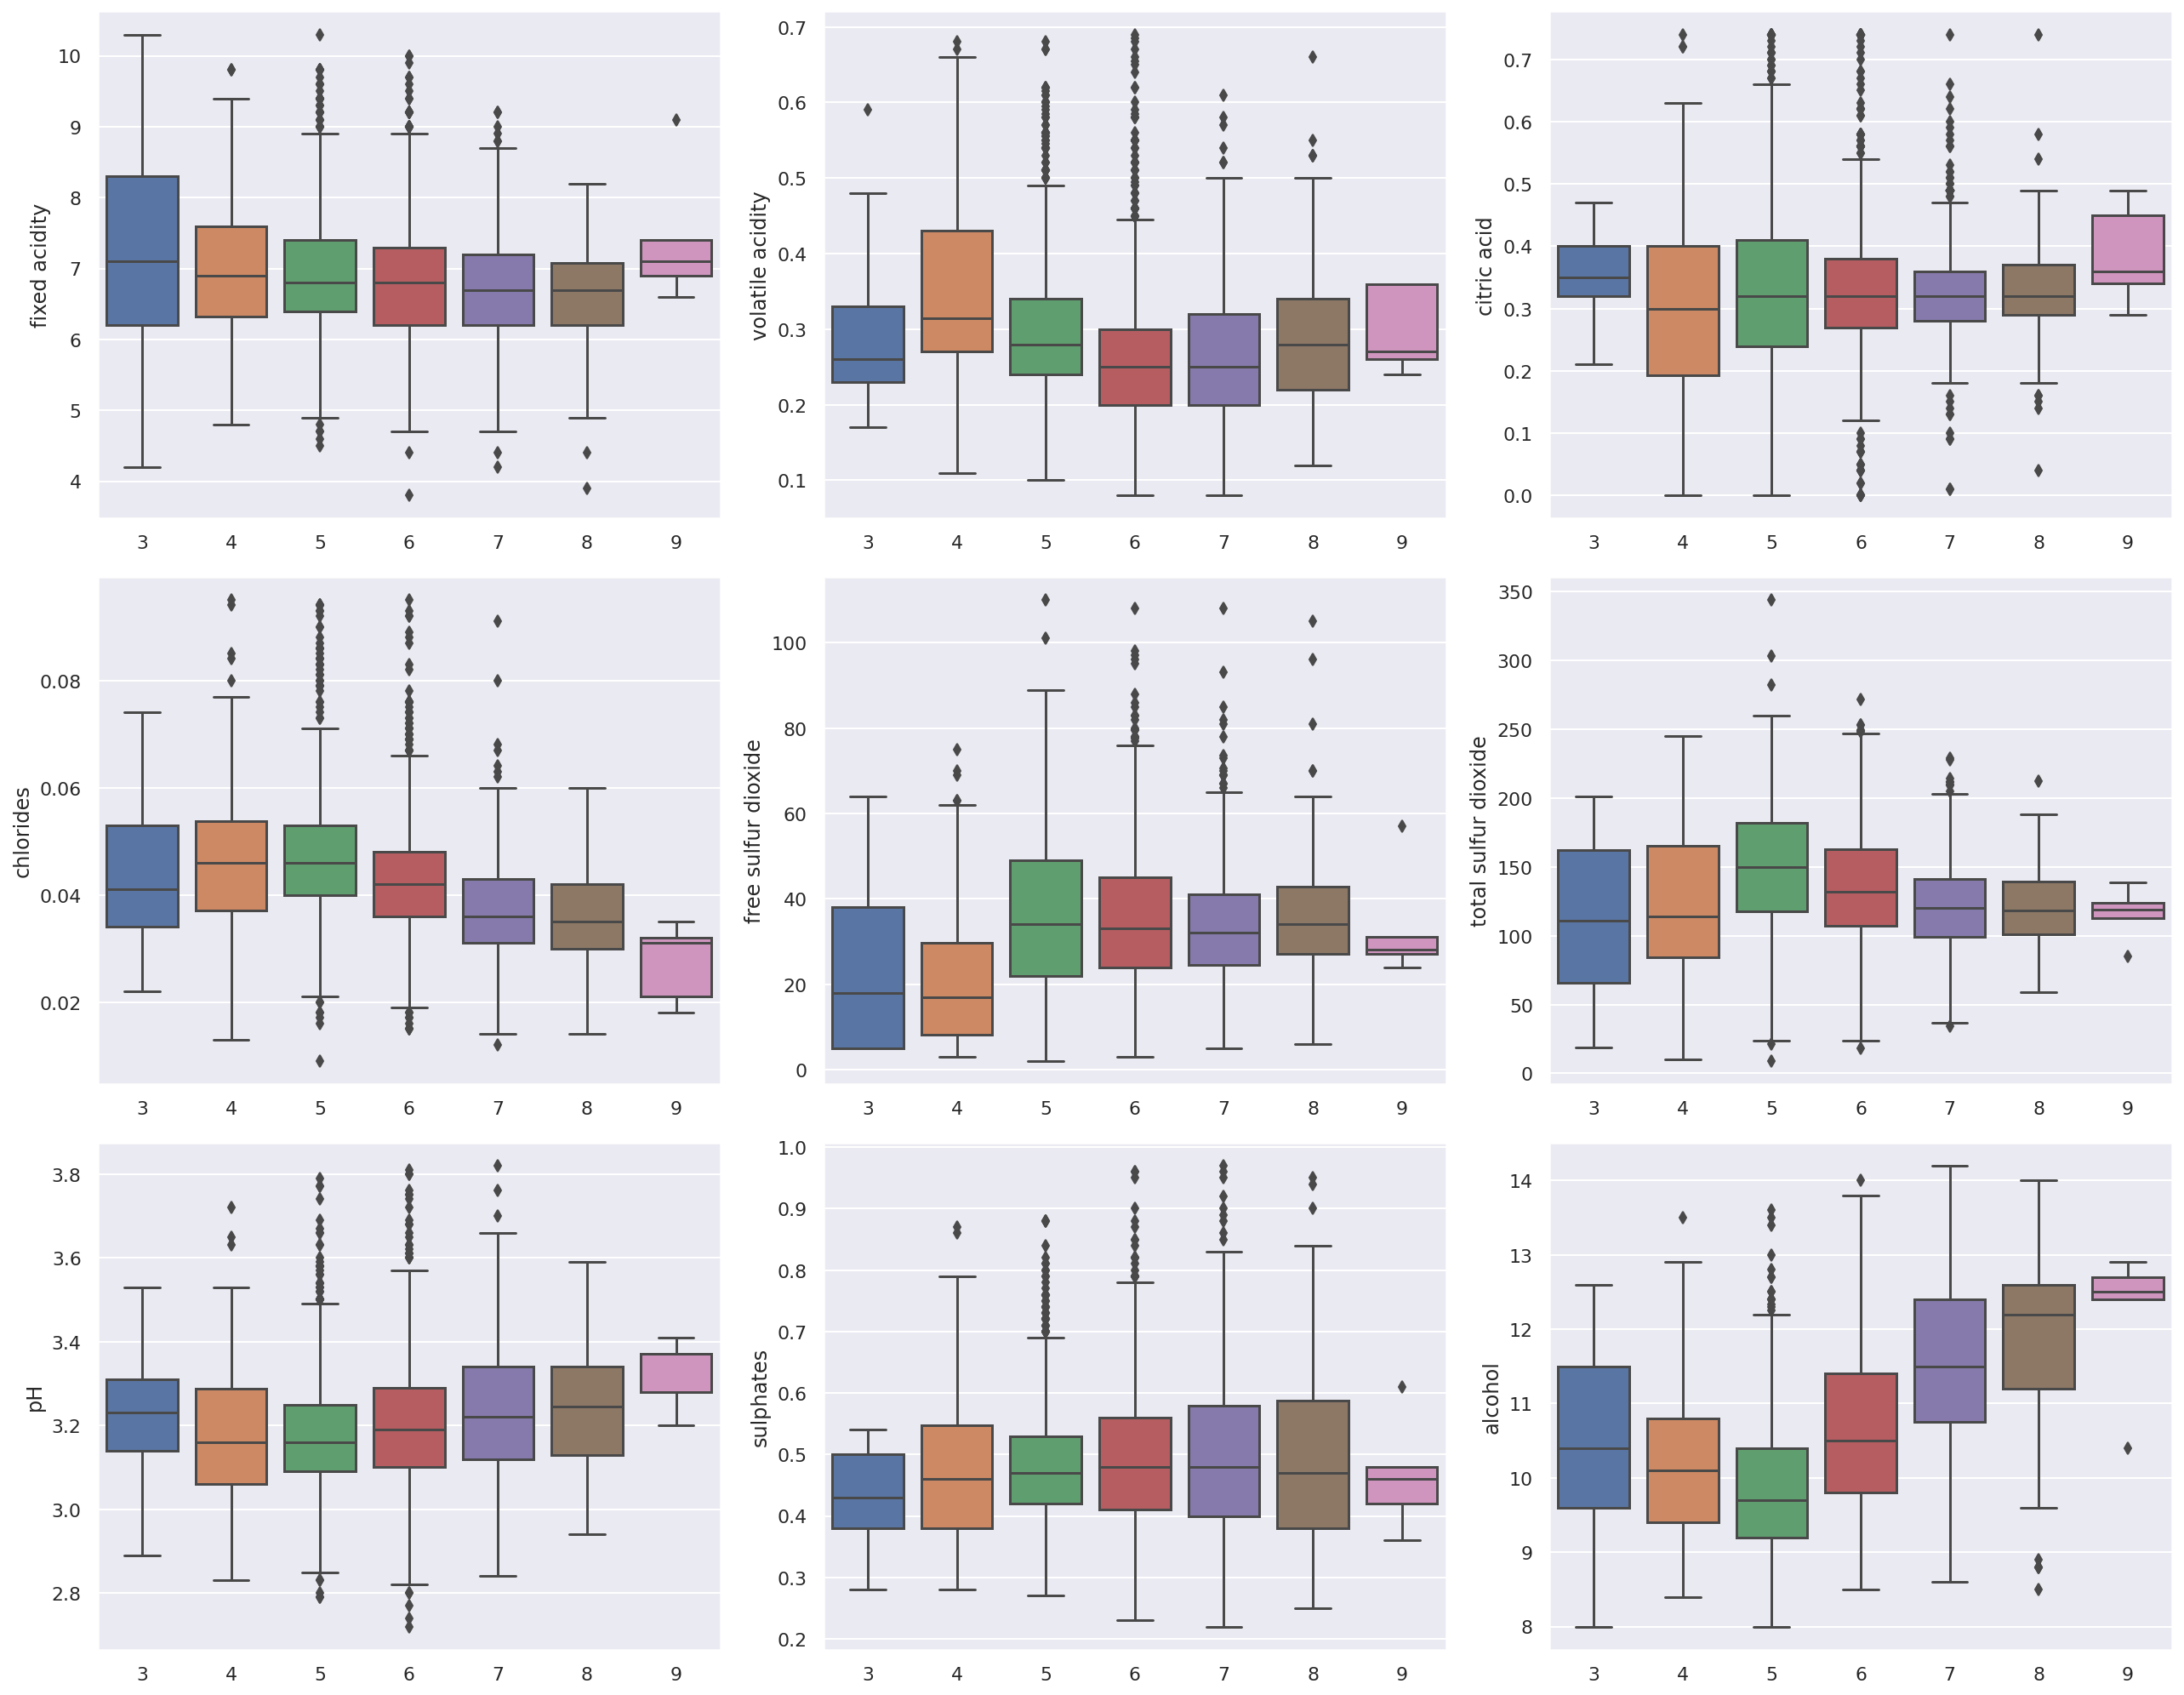

In [135]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 14))
for idx, feat in enumerate(df.drop('quality', 1).columns):
    ax = axes[int(idx / 3), idx % 3]
    sns.boxplot(x='quality', y=feat, data=df, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel(feat)
fig.tight_layout()

The most pronounce pattern we observe for `alcohol`, which is expected as this feature has the strongest correlation with the dependant variable. The relationship higher `alcohol percentage` - higher `wine quality` does not seem linear though.

Wine sorts of highe quality tend to have lower chlorides shares than those of lower quality.

### 5) Feature Importance

Further, we apply two feature selection tchniques to find out what input features are most useful at predicting a target variable.

#### a) Mutual Information Statistics

Mutual information from the field of information theory is the application of information gain (typically used in the construction of decision trees) to feature selection. Mutual information is calculated between two variables and measures the reduction in uncertainty for one variable given a known value of the other variable.

In [136]:
X, y = df.drop('quality', 1).values, df.loc[: ,'quality'].values

In [137]:
fs = SelectKBest(score_func=mutual_info_classif, k='all')
fs.fit(X, y)

SelectKBest(k='all',
            score_func=<function mutual_info_classif at 0x7f994c7ea320>)

In [138]:
feat_importance = pd.DataFrame({ 'feature': df.drop('quality', 1).columns, 'score': fs.scores_ }).sort_values(by='score', ascending=False).reset_index(drop=True)
display(feat_importance)

,feature,score
0,alcohol,0.158807
1,chlorides,0.065217
2,total sulfur dioxide,0.048553
3,volatile acidity,0.035423
4,citric acid,0.032546
5,free sulfur dioxide,0.030107
6,pH,0.025548
7,sulphates,0.023398
8,fixed acidity,0.012767


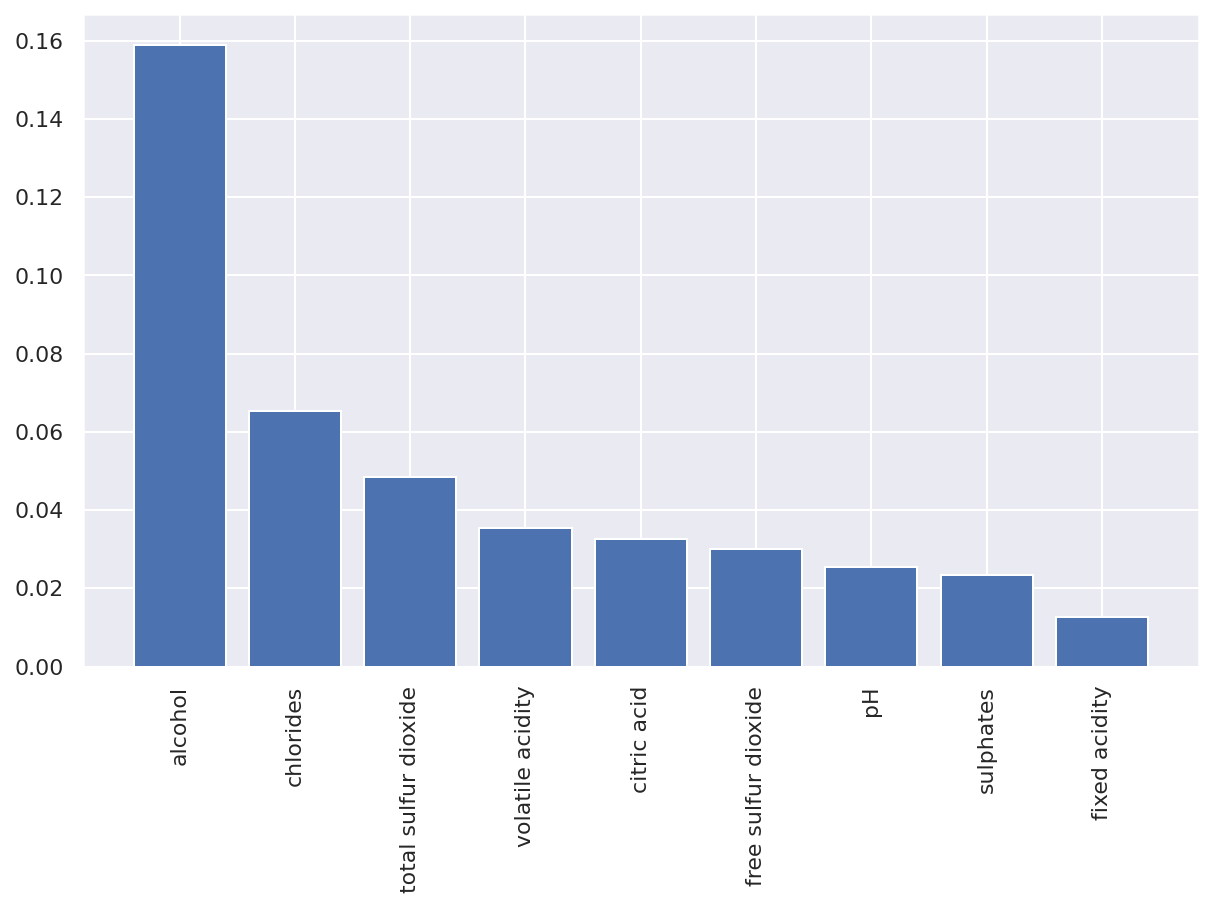

In [139]:
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
plt.bar(x=feat_importance.feature, height=feat_importance.score)
plt.xticks(rotation='vertical')
plt.show()

According to mutual information statistics, `alcohol` is the most important feature which conforms with results of our correlation analysis.

#### b) ANOVA F-test Feature Selection

ANOVA is an acronym for analysis of variance and is a parametric statistical hypothesis test for determining whether the means from two or more samples of data (often three or more) come from the same distribution or not. An F-statistic, or F-test, is a class of statistical tests that calculate the ratio between variances values, such as the variance from two different samples or the explained and unexplained variance by a statistical test, like ANOVA.

In [140]:
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(X, y)

SelectKBest(k='all', score_func=<function f_classif at 0x7f994f948b90>)

In [141]:
feat_importance = pd.DataFrame({ 'feature': df.drop('quality', 1).columns, 'score': fs.scores_ }).sort_values(by='score', ascending=False).reset_index(drop=True)
display(feat_importance)

,feature,score
0,alcohol,209.738540
1,chlorides,72.154674
2,total sulfur dioxide,39.455545
3,volatile acidity,37.013554
4,free sulfur dioxide,17.463808
5,pH,10.861388
6,fixed acidity,9.732531
7,sulphates,2.947532
8,citric acid,1.663571


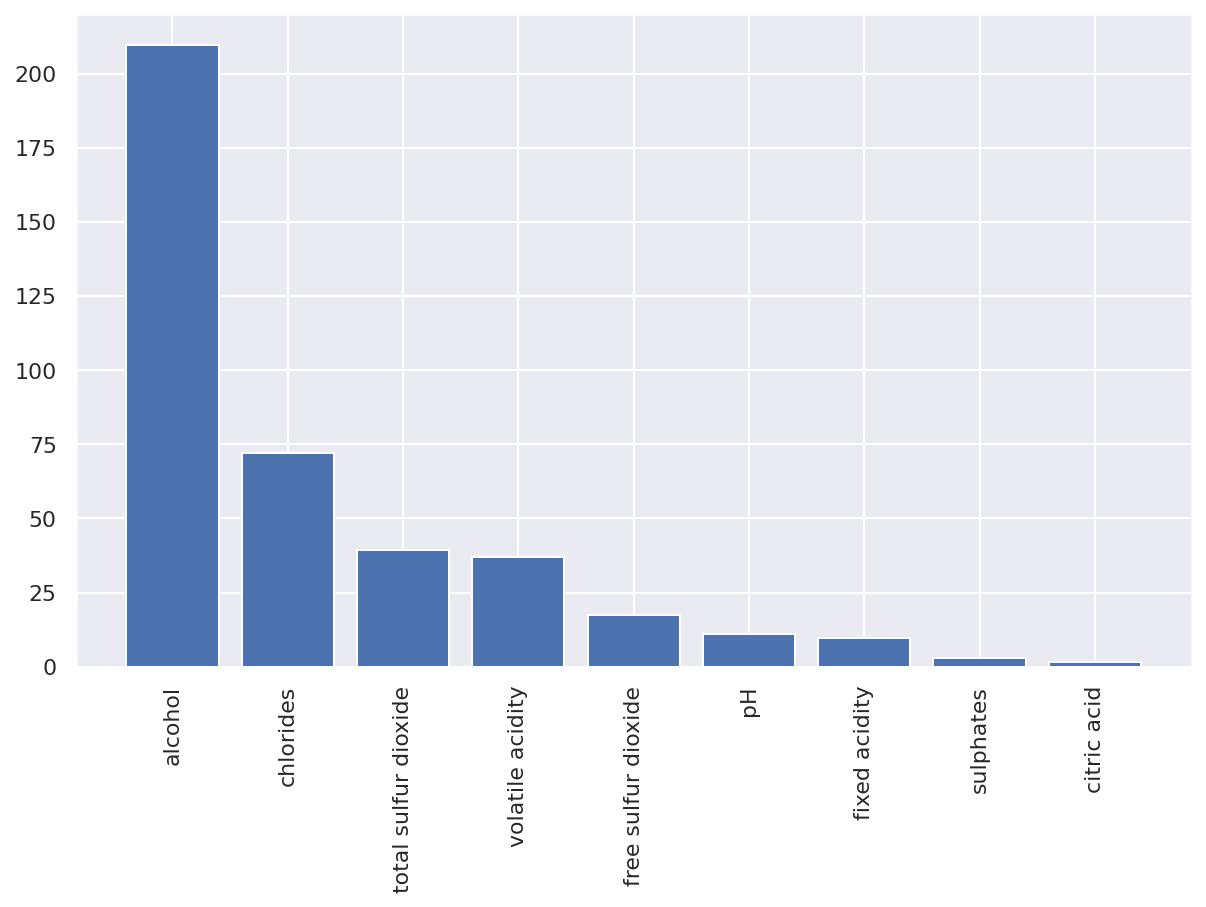

In [142]:
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
plt.bar(x=feat_importance.feature, height=feat_importance.score)
plt.xticks(rotation='vertical')
plt.show()

Analysis of variance provides us with the same results as the mutual information method. 'alcohol' is the most influential feature followed by `chlorides`.

### 6) Baseline Model

As a baseline model we will use 5-nearest-neighbors-classifier, which score we will then try to improve. For assessing the effectiveness of your model we will use [stratified k-fold cross-validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html).

In [143]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
clf = KNeighborsClassifier(n_neighbors=5)

scores = cross_val_score(clf, X, y, cv=kfold)
print('Cross-validation scores: {}'.format(scores))
print('Average cross-validation score: {}'.format(round(scores.mean(), 3)))

Cross-validation scores: [0.40526316 0.42105263 0.41973684 0.41238472 0.4229249 ]
Average cross-validation score: 0.416


The model predicts our classes with 41 % accuracy. There is definitely some room for improvement!

## PREPARE DATA

### 1) Oversampling

The challenge of working with imbalanced datasets is that most machine learning techniques will ignore, and in turn have poor performance on, the minority class, although typically it is performance on the minority class that is most important.

For this project, we will use [SMOTEENN](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTEENN.html#imblearn.combine.SMOTEENN) technique (over-sampling using SMOTE and cleaning using ENN) from the **imbalanced learn** library. This method combines over- (to oversample the minority classes) and undersampling (to trim the number of examples in the majority classes).

In [144]:
# initial classes distribution after data cleaning
pd.Series(y).value_counts()

6    1725
5    1104
7     683
4     138
8     130
3      13
9       5
dtype: int64

In [145]:
oversample = SMOTEENN(smote=SMOTE(k_neighbors=4), random_state=seed)
# transform the dataset
X, y = oversample.fit_resample(X, y)

In [146]:
# classes distribution after oversampling
pd.Series(y).value_counts()

9    1703
3    1496
8    1339
4    1219
7     782
5     410
6      96
dtype: int64

We now have more data points for our minority classes and less data points for majority classes.

### 2) Feature Engineering

For generating new features we are using [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) technique from the preprocessing module of the Scikit-Learn library. PolynomialFeatures generates a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. For example, if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].

In [147]:
poly = PolynomialFeatures(degree=2).fit(X)
X_poly = poly.transform(X)

print('X_poly.shape: {}'.format(X_poly.shape))

X_poly.shape: (7045, 55)


In [148]:
df_poly = pd.DataFrame(np.hstack([X_poly, y.reshape(-1,1)]), columns=poly.get_feature_names()+['target'])
df_poly.head()

,1,x0,x1,x2,x3,x4,x5,x6,x7,x8,x0^2,x0 x1,x0 x2,x0 x3,x0 x4,x0 x5,x0 x6,x0 x7,x0 x8,x1^2,x1 x2,x1 x3,x1 x4,x1 x5,x1 x6,x1 x7,x1 x8,x2^2,x2 x3,x2 x4,x2 x5,x2 x6,x2 x7,x2 x8,x3^2,x3 x4,x3 x5,x3 x6,x3 x7,x3 x8,x4^2,x4 x5,x4 x6,x4 x7,x4 x8,x5^2,x5 x6,x5 x7,x5 x8,x6^2,x6 x7,x6 x8,x7^2,x7 x8,x8^2,target
0,1.0,8.5,0.26,0.21,0.074,41.0,197.0,3.02,0.50,9.8,72.25,2.210,1.785,0.6290,348.5,1674.5,25.670,4.250,83.30,0.0676,0.0546,0.01924,10.66,51.22,0.7852,0.1300,2.548,0.0441,0.01554,8.61,41.37,0.6342,0.1050,2.058,0.005476,3.034,14.578,0.22348,0.03700,0.7252,1681.0,8077.0,123.82,20.50,401.8,38809.0,594.94,98.50,1930.6,9.1204,1.5100,29.596,0.2500,4.900,96.04,3.0
1,1.0,5.8,0.24,0.44,0.029,5.0,109.0,3.53,0.43,11.7,33.64,1.392,2.552,0.1682,29.0,632.2,20.474,2.494,67.86,0.0576,0.1056,0.00696,1.20,26.16,0.8472,0.1032,2.808,0.1936,0.01276,2.20,47.96,1.5532,0.1892,5.148,0.000841,0.145,3.161,0.10237,0.01247,0.3393,25.0,545.0,17.65,2.15,58.5,11881.0,384.77,46.87,1275.3,12.4609,1.5179,41.301,0.1849,5.031,136.89,3.0
2,1.0,9.1,0.59,0.38,0.066,34.0,182.0,3.23,0.38,8.5,82.81,5.369,3.458,0.6006,309.4,1656.2,29.393,3.458,77.35,0.3481,0.2242,0.03894,20.06,107.38,1.9057,0.2242,5.015,0.1444,0.02508,12.92,69.16,1.2274,0.1444,3.230,0.004356,2.244,12.012,0.21318,0.02508,0.5610,1156.0,6188.0,109.82,12.92,289.0,33124.0,587.86,69.16,1547.0,10.4329,1.2274,27.455,0.1444,3.230,72.25,3.0
3,1.0,7.1,0.32,0.32,0.038,16.0,66.0,3.24,0.40,11.5,50.41,2.272,2.272,0.2698,113.6,468.6,23.004,2.840,81.65,0.1024,0.1024,0.01216,5.12,21.12,1.0368,0.1280,3.680,0.1024,0.01216,5.12,21.12,1.0368,0.1280,3.680,0.001444,0.608,2.508,0.12312,0.01520,0.4370,256.0,1056.0,51.84,6.40,184.0,4356.0,213.84,26.40,759.0,10.4976,1.2960,37.260,0.1600,4.600,132.25,3.0
4,1.0,6.9,0.39,0.40,0.022,5.0,19.0,3.31,0.37,12.6,47.61,2.691,2.760,0.1518,34.5,131.1,22.839,2.553,86.94,0.1521,0.1560,0.00858,1.95,7.41,1.2909,0.1443,4.914,0.1600,0.00880,2.00,7.60,1.3240,0.1480,5.040,0.000484,0.110,0.418,0.07282,0.00814,0.2772,25.0,95.0,16.55,1.85,63.0,361.0,62.89,7.03,239.4,10.9561,1.2247,41.706,0.1369,4.662,158.76,3.0


The dimensionality of our data was increased up to 56 variables which is way beyond the number of original data. However,
adding more features makes all models more complex, and so increases the chance of overfitting. When adding new features, or with high-dimensional datasets in general, it can be a good idea to reduce the number of features to only the most useful ones, and discard the rest. This can lead to simpler models that generalize better.

### 3) Feature Selection

Iterative Feature Selection

In iterative feature selection, a series of models are built, with varying numbers of features. There are two basic methods: starting with no features and adding features one by one until some stopping criterion is reached, or starting with all features and removing features one by one until some stopping criterion is reached. Because a series of models are built, these methods are much more computationally expensive than the methods we discussed previously. One particular method of this kind is [recursive feature elimination (RFE)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html?highlight=rfe#sklearn.feature_selection.RFE), which starts with all features, builds a model, and discards the least important feature according to the model. Then a new model is built using all but the discarded feature, and so on until only a prespecified number of features are left.

In [149]:
# selecting 30 most important features
select = RFE(RandomForestRegressor(n_estimators=50, max_depth=10, random_state=seed), n_features_to_select=30)
X_rfe = select.fit_transform(X_poly, y)
print('X_rfe.shape: {}'.format(X_rfe.shape))

X_rfe.shape: (7045, 30)


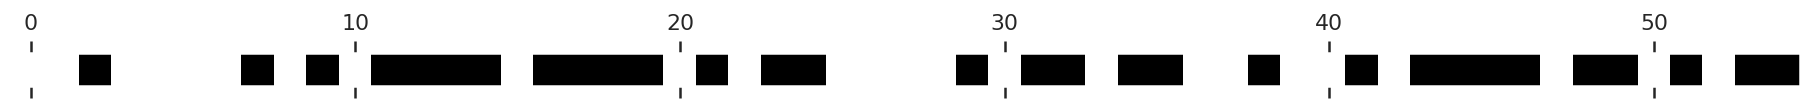

In [150]:
# visualize the selected features
mask = select.get_support()
plt.matshow(mask.reshape(1,-1), cmap='gray_r')
plt.yticks(());

Ok, it took a few minutes, but now we have much more compact dataset. This will reduce training time and prevent overfitting.

### 4) Normalize Data

Next, we rescale our data using [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standardscaler#sklearn.preprocessing.StandardScaler), so that the mean of all feature equals 0 and standard deviation equals 1.

In [151]:
X_rfe_scaled = StandardScaler().fit_transform(X_rfe)

In [152]:
pd.DataFrame(X_rfe_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
count,7.045000e+03,7.045000e+03,7.045000e+03,7.045000e+03,7.045000e+03,7.045000e+03,7.045000e+03,7.045000e+03,7.045000e+03,7.045000e+03,7.045000e+03,7.045000e+03,7.045000e+03,7.045000e+03,7.045000e+03,7.045000e+03,7.045000e+03,7.045000e+03,7.045000e+03,7.045000e+03,7.045000e+03,7.045000e+03,7.045000e+03,7.045000e+03,7.045000e+03,7.045000e+03,7.045000e+03,7.045000e+03,7.045000e+03,7.045000e+03
mean,-5.183221e-16,-2.797226e-16,-1.014511e-15,-2.289471e-16,7.542267e-17,3.795954e-16,-5.674981e-16,4.940138e-16,5.866768e-16,-9.582745e-16,-1.148896e-15,-9.093191e-16,-1.595955e-16,-1.358349e-16,-4.054245e-16,2.861838e-17,3.733785e-16,2.912109e-16,-8.717102e-17,5.849118e-16,-2.858608e-16,7.234573e-17,-4.781366e-16,-1.497964e-16,2.826361e-16,1.137696e-16,-2.035829e-16,1.923625e-16,-1.712990e-15,1.028851e-15
std,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00
min,-2.583032e+00,-3.134160e+00,-2.483525e+00,-2.387034e+00,-2.956025e+00,-1.990875e+00,-1.837949e+00,-3.267830e+00,-2.543716e+00,-3.650559e+00,-1.501486e+00,-1.611645e+00,-1.976859e+00,-2.542157e+00,-1.701657e+00,-3.714426e+00,-3.129021e+00,-1.263011e+00,-1.440955e+00,-1.828902e+00,-1.388843e+00,-1.606820e+00,-1.740395e+00,-1.605758e+00,-2.749353e+00,-3.042914e+00,-2.962445e+00,-2.268201e+00,-2.027487e+00,-2.230969e+00
25%,-6.397981e-01,-6.760550e-01,-7.847886e-01,-6.224312e-01,-6.061411e-01,-6.892926e-01,-7.289175e-01,-6.759110e-01,-7.335558e-01,-7.160217e-01,-6.129912e-01,-6.515538e-01,-5.410552e-01,-6.246206e-01,-7.897985e-01,-5.580296e-01,-5.688239e-01,-6.080767e-01,-7.077170e-01,-6.493331e-01,-7.459704e-01,-7.067554e-01,-7.327566e-01,-6.419951e-01,-5.586509e-01,-5.055863e-01,-6.882811e-01,-8.224668e-01,-6.358402e-01,-8.234523e-01
50%,-1.721399e-01,5.154885e-02,1.248447e-01,-9.866997e-02,-8.787089e-02,-1.531286e-01,3.067553e-02,-1.402028e-02,-8.127106e-02,1.443371e-01,-2.629576e-01,-3.331293e-01,-1.910434e-01,-1.529957e-01,-1.907126e-02,2.311263e-02,-6.044367e-02,-3.127406e-01,-2.138039e-01,-3.039540e-01,-1.425171e-01,-5.256311e-02,1.687268e-02,-2.145419e-01,-4.191315e-02,9.018913e-02,3.156031e-02,9.938003e-02,-1.767640e-01,6.959026e-02
75%,4.767713e-01,6.855373e-01,9.410977e-01,4.582138e-01,6.070139e-01,4.507286e-01,6.718450e-01,5.234340e-01,6.240472e-01,8.304715e-01,3.102732e-01,3.531050e-01,3.222567e-01,4.643007e-01,5.961813e-01,6.398294e-01,5.687145e-01,3.415834e-01,4.471503e-01,5.203444e-01,5.216640e-01,5.169890e-01,6.209681e-01,3.472886e-01,4.740789e-01,6.352822e-01,6.761710e-01,8.825342e-01,5.092888e-01,9.536947e-01
max,4.322473e+00,4.316970e+00,2.208597e+00,5.012758e+00,4.732706e+00,4.112057e+00,4.920316e+00,2.569353e+00,5.903886e+00,2.323831e+00,5.795634e+00,6.973592e+00,5.490796e+00,4.290186e+00,5.634905e+00,4.631579e+00,9.560217e+00,6.382829e+00,6.727204e+00,6.532214e+00,6.859421e+00,8.976969e+00,5.069705e+00,1.022174e+01,5.290707e+00,5.032817e+00,4.680415e+00,2.368002e+00,5.638549e+00,2.481675e+00


As we can see, all of our variables have now mean value close to 0 and standard deviation close to 1.

## MODELLING

### 1) Instantiate the models

We are going to test nine classifier algorithms:

1) [K-Nearest-Neighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=neighbors#sklearn.neighbors.KNeighborsClassifier): the algorithm finds the predefined number of points in the training set that are closest to the new point. Then it assigns the majority class of these training points to the new data point.

2) [Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontreeclassifier#sklearn.tree.DecisionTreeClassifier): the algorithm predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

3) [Linear Support Vector Classification](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html?highlight=linearsvc#sklearn.svm.LinearSVC): the objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.

4) [Naive Bayes Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html?highlight=gaussiannb#sklearn.naive_bayes.GaussianNB): Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.

5) [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforestclassifier#sklearn.ensemble.RandomForestClassifier): A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

6) [Support Vector Classification](https://scikit-learn.org/stable/modules/svm.html#svm-classification): The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.

7) [Gradient Boosting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html?highlight=gradientboostingclassifier#sklearn.ensemble.GradientBoostingClassifier): GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions.

8) [Extra Trees Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html?highlight=extratreesclassifier#sklearn.ensemble.ExtraTreesClassifier): This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

9) [AdaBoost Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html): An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

In [153]:
# prepare data for modelling
X_train, X_test, y_train, y_test = train_test_split(X_rfe_scaled, y, test_size=0.25, random_state=seed)

In [154]:
# create lists to collect model names & results
models, names = [], []
accuracy, f1 = [], []
recall, precision = [], []

# define models to rain
models.append(('5-NN', KNeighborsClassifier(n_neighbors=5)))
models.append(('Decision Tree Classifier', DecisionTreeClassifier(random_state=seed, max_depth=20, max_features=8, min_samples_leaf=5)))
models.append(('Linear Support Vector Classification', LinearSVC(random_state=seed, tol=1e-5, C=100)))
models.append(('Naive Bayes Classifier', GaussianNB()))
models.append(('Random Forest Classifier', RandomForestClassifier(random_state=seed)))
models.append(('Kernelized Support Vector Machines', SVC(kernel='rbf', C=1000, gamma=1/X_rfe_scaled.shape[1])))
models.append(('Gradient Boosting Classifier', GradientBoostingClassifier(random_state=seed)))
models.append(('Extra Trees Classifier', ExtraTreesClassifier(random_state=seed)))
models.append(('AdaBoost Classifier', AdaBoostClassifier(random_state=seed)))

### 2) Fit the models

In [155]:
# train models & collect results
for name, model in models:
  names.append(name)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
  accuracy.append(accuracy_score(y_test, y_pred))
  precision.append(model_precision)
  recall.append(model_recall)
  f1.append(model_f1)

# put results in dataframe
fin_scores = pd.DataFrame( { 'models': names, 
                             'accuracy': accuracy,
                             'f1_score': f1,
                             'recall': recall,
                             'precision': precision} ).sort_values(by=['accuracy', 'f1_score'], ascending=False).set_index('models')

### 3) Evaluate performance

In [156]:
# display results
display(fin_scores)

,accuracy,f1_score,recall,precision
models,,,,
Extra Trees Classifier,0.964813,0.962121,0.964813,0.961700
Random Forest Classifier,0.954030,0.950937,0.954030,0.951244
Kernelized Support Vector Machines,0.953462,0.952402,0.953462,0.952892
Gradient Boosting Classifier,0.913734,0.908048,0.913734,0.909457
5-NN,0.913167,0.903795,0.913167,0.903765
Decision Tree Classifier,0.877980,0.874338,0.877980,0.871480
Linear Support Vector Classification,0.676504,0.668522,0.676504,0.668886
Naive Bayes Classifier,0.612372,0.625279,0.612372,0.661467
AdaBoost Classifier,0.523269,0.454729,0.523269,0.418772


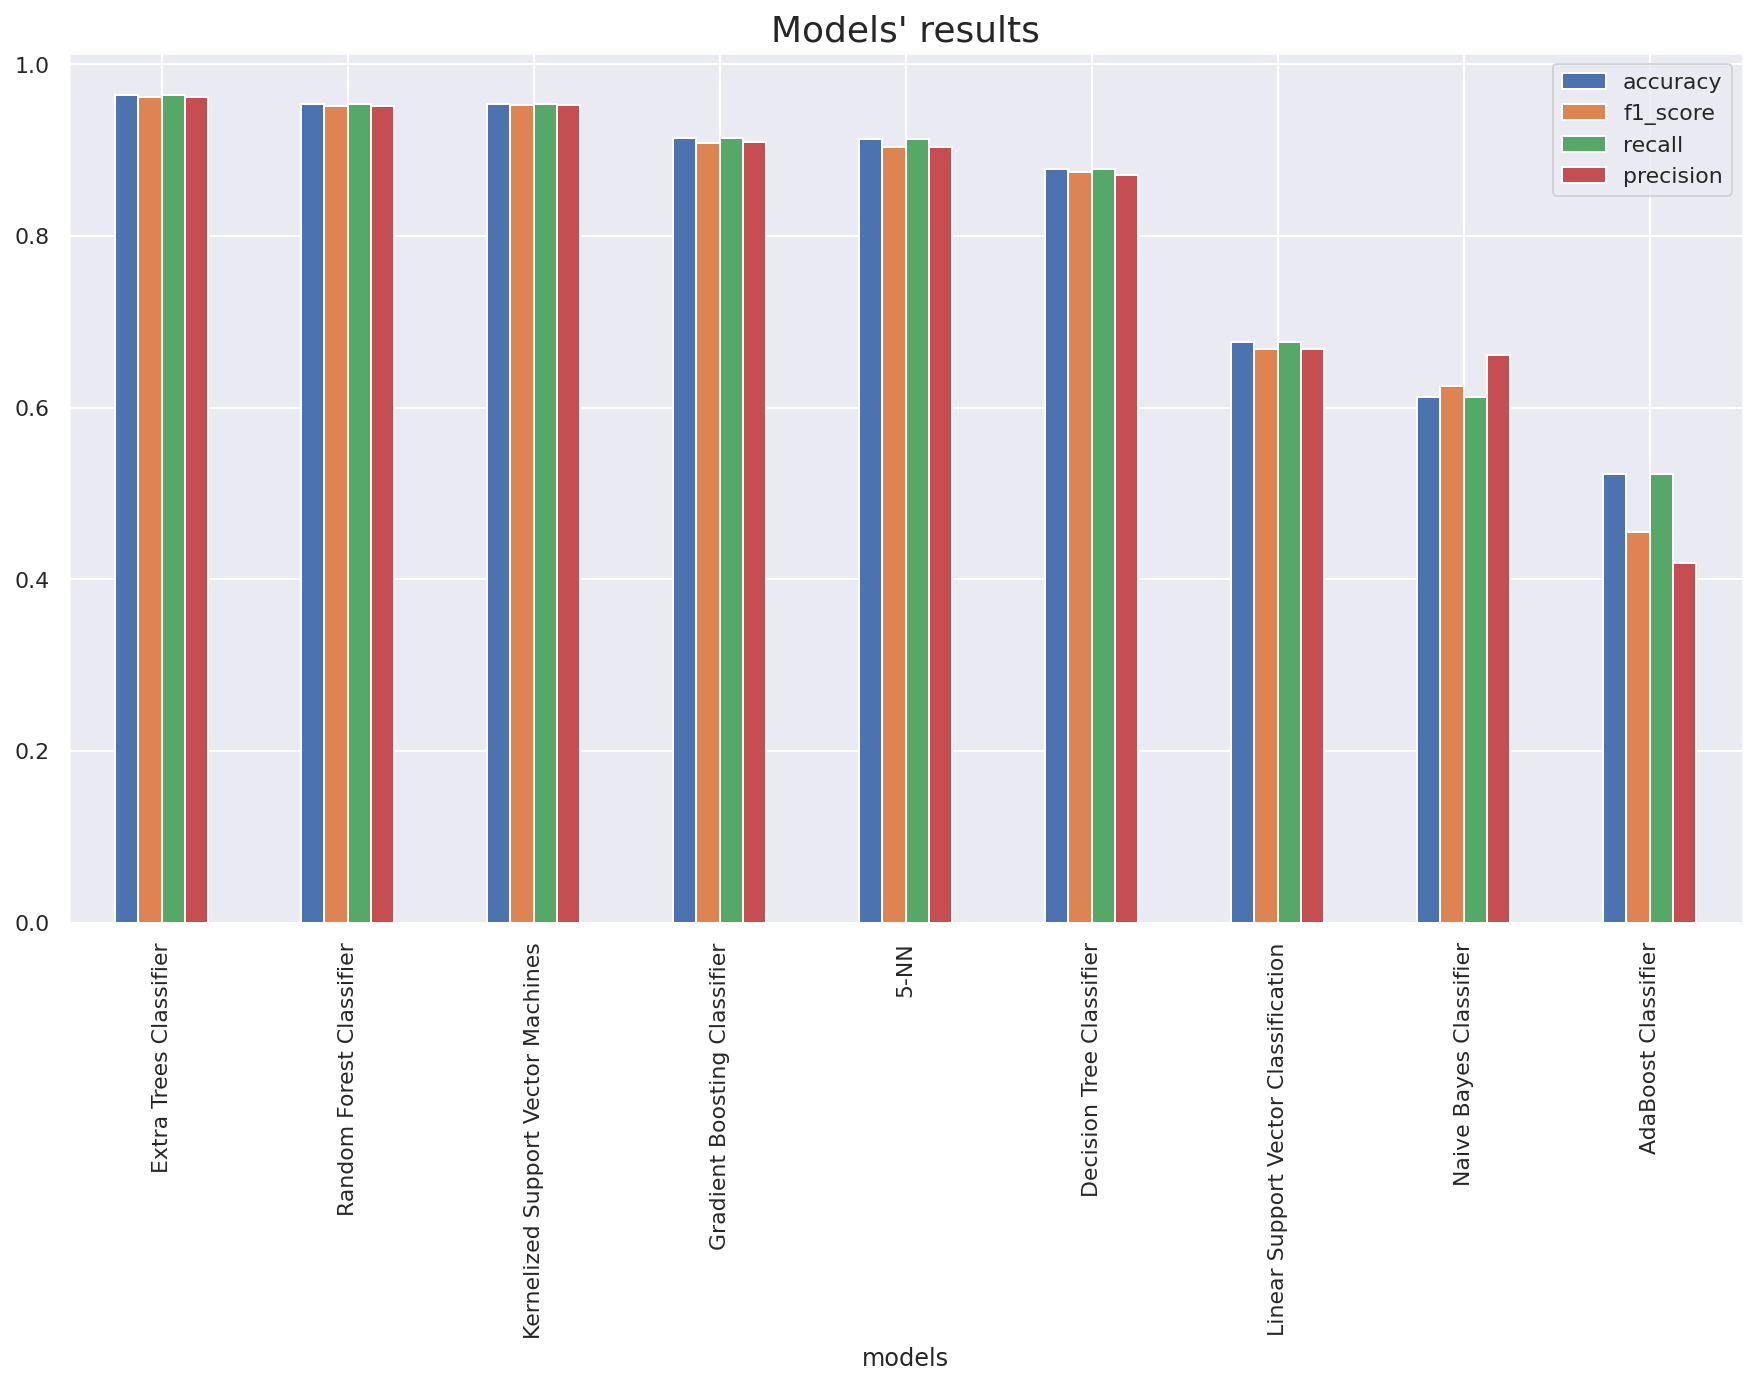

In [157]:
# Plot and compare all of the model results
fin_scores.plot(kind="bar", figsize=(15, 8)).legend(bbox_to_anchor=(1.0, 1.0));
plt.title("Models' results", fontsize=18);

As we can see, the highest results have been achieved by the bagging algorithm **Extra Trees Classifier**.

Let's now tune its hyperparameters and try to improve our metrics.

### 4) Fine-tune hyperparameters

In [158]:
kfold = KFold(n_splits=5, shuffle=True, random_state=29)
scoring = 'accuracy'

In [159]:
model = ExtraTreesClassifier(random_state=seed)

param_grid = { 'n_estimators': [100, 200, 300], 
               'criterion': ['gini', 'entropy'], 
               'max_depth': [10, 15, 20],
               'min_samples_split': [2, 3, 4],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_leaf_nodes': [None, 3, 6, 9] }

grid_search = RandomizedSearchCV(model, 
                                 param_distributions=param_grid, 
                                 cv=kfold,
                                 n_iter=45,
                                 n_jobs=-1,
                                 scoring=scoring,
                                 random_state=29)

In [160]:
grid_search.fit(X_rfe_scaled, y)
print(f"Best cross-validation accuracy: {round(grid_search.best_score_ * 100, 2)}%")
print("Best parameters: ", grid_search.best_params_)

Best cross-validation accuracy: 96.76%
Best parameters:  {'n_estimators': 300, 'min_samples_split': 2, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'gini'}


We managed to improve our accuracy with the tuned hyperparameters a smidge. Overall, all our advanced models performed very well.